The steps of Canny edge detector:

    1- Smooth image with Gaussian.
    2- Calculate magnitude and orientation of gradient.
    3- Non-max suppression.
    4- Threshold.


Import libraries :

In [13]:
import numpy as np
import cv2
import argparse
import matplotlib.pyplot as plt
import math

#1-Smooth image with Gaussian

The density() function returns the density using the mean = 0 and sigma in the formula of Univariate Normal Distribution : 

In [14]:
def density(x, mean, sigma):
    return 1 / (np.sqrt(2 * np.pi) * sigma) * np.exp(-np.power((x - mean) / sigma, 2) / 2)

*The* gaussian_filter() function, which takes the size of the filter and sigma, and returns the filter_2D : 

In [15]:
def gaussian_filter(size, sigma):
    filter_1D = np.linspace(-(size // 2), size // 2, size)
    for i in range(size):
        filter_1D[i] = density(filter_1D[i], 0, sigma)

    filter_2D = np.outer(filter_1D.T, filter_1D.T)
    filter_2D *= 1.0 / filter_2D.max()

    return filter_2D

The convolution function :

In [16]:
def convolution(image, filter):

    print("The filter shape : {}".format(filter.shape))
    print("The origine image shape : {}".format(image.shape))

    #Show the origine image (BGR)
    #plt.imshow(image)
    #plt.title("Origine image (BGR)")
    #plt.show()

    #if the image is not gray
    if len(image.shape) == 3: 
        print("\nThe image is not gray.")
        #Converte the image to Gray : 
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        print("Converte the image to gray.\nGray image shape : {}".format(image.shape))
    else: #if the image is gray
        print("The image is already gray.\nGray image shape : {}".format(image.shape))

    #Show the gray image
    #plt.imshow(image, cmap='gray')
    #plt.title("Gray image")
    #plt.show()
    #save the image : 
    cv2.imwrite("1_gray.jpg", image)

 
    image_row, image_col = image.shape
    filter_row, filter_col = filter.shape
 
    output = np.zeros(image.shape)
 
    pad_height = int((filter_row - 1) / 2)
    pad_width = int((filter_col - 1) / 2)
 
    padded_image = np.zeros((image_row + (2 * pad_height), image_col + (2 * pad_width)))
 
    padded_image[pad_height:padded_image.shape[0] - pad_height, pad_width:padded_image.shape[1] - pad_width] = image
 
    #Show the padded image
    #plt.imshow(padded_image, cmap='gray')
    #plt.title("Padded image")
    #plt.show()
    #save the image : 
    cv2.imwrite("2_padded.jpg", padded_image)
 
    for row in range(image_row):
        for col in range(image_col):
            #The convolution operation :
            output[row, col] = np.sum(filter * padded_image[row:row + filter_row, col:col + filter_col])

            #apply the blur effect :
            output[row, col] /= filter.shape[0] * filter.shape[1]
 
    print("The output image shape : {}".format(output.shape))
 
    #Show the output image
    plt.imshow(output, cmap='gray')
    plt.title("Output Image after the filter")
    plt.show()
    #save the image : 
    cv2.imwrite("3_convol.jpg", output)

 
    return output

Smoothing with sigma σ = 5

In [17]:
def gaussian_blur(image, filter_size):
    filter = gaussian_filter(filter_size, sigma=5)
    return convolution(image, filter)

In [ ]:
#Load image
image = cv2.imread('test.jpg')
blur_img = gaussian_blur(image, 5)
#save the image : 
cv2.imwrite("4_blur.jpg", blur_img)

#2-Calculate magnitude and orientation of gradient

To calculating the magnitude and the direction of the gradient : 

In [19]:
def sobel_edge_detection(image, filter, convert_to_degree=False):
    image_horizontal = convolution(image, filter)

    #Show image (horizontal mask)
    #plt.imshow(image_horizontal, cmap='gray')
    #plt.title("Image using horizontal Edge")
    #plt.show()
    #save the image : 
    cv2.imwrite("5_horizontal.jpg", image_horizontal)
    

    image_vertical = convolution(image, np.flip(filter.T, axis=0))

    #Show image (vertical mask)
    #plt.imshow(image_vertical, cmap='gray')
    #plt.title("Image using vertical Edge")
    #plt.show()
    #save the image : 
    cv2.imwrite("6_vertical.jpg", image_vertical)

    #combine the vertical and horizontal 
    gradient_magnitude = np.sqrt(np.square(image_horizontal) + np.square(image_vertical))
    #normalize to be between 0 and 255.
    gradient_magnitude *= 255.0 / gradient_magnitude.max()

    #Show image (vertical and horizontal mask)
    #plt.imshow(gradient_magnitude, cmap='gray')
    #plt.title("Gradient Magnitude")
    #plt.show()
    #save the image : 
    cv2.imwrite("7_magnitude.jpg", gradient_magnitude)


    #calculate the gradient direction :
    gradient_direction = np.arctan2(image_vertical, image_horizontal)

    #convert gradient direction to degree
    gradient_direction = np.rad2deg(gradient_direction)
    #make the degree be between 0 to 360
    gradient_direction += 180

    return gradient_magnitude, gradient_direction

In [ ]:
#load the image
image = cv2.imread('test.jpg')

blur_image = gaussian_blur(image, filter_size=9)
edge_filter = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
gradient_magnitude, gradient_direction = sobel_edge_detection(blur_image, edge_filter, convert_to_degree=True)


#3- Non-max suppression

In [21]:
def non_max_suppression(gradient_magnitude, gradient_direction):

    image_row, image_col = gradient_magnitude.shape
 
    output = np.zeros(gradient_magnitude.shape)
    pi = 180
 
    #loop through all pixels in gradient directions
    for row in range(1, image_row - 1):
        for col in range(1, image_col - 1):
            direction = gradient_direction[row, col]
 
            if (0 <= direction < pi / 8) or (15 * pi / 8 <= direction <= 2 * pi):
                before_pixel = gradient_magnitude[row, col - 1]
                after_pixel = gradient_magnitude[row, col + 1]
 
            elif (pi / 8 <= direction < 3 * pi / 8) or (9 * pi / 8 <= direction < 11 * pi / 8):
                before_pixel = gradient_magnitude[row + 1, col - 1]
                after_pixel = gradient_magnitude[row - 1, col + 1]
 
            elif (3 * pi / 8 <= direction < 5 * pi / 8) or (11 * pi / 8 <= direction < 13 * pi / 8):
                before_pixel = gradient_magnitude[row - 1, col]
                after_pixel = gradient_magnitude[row + 1, col]
 
            else:
                before_pixel = gradient_magnitude[row - 1, col - 1]
                after_pixel = gradient_magnitude[row + 1, col + 1]
 
            if gradient_magnitude[row, col] >= before_pixel and gradient_magnitude[row, col] >= after_pixel:
                output[row, col] = gradient_magnitude[row, col]
 
    #Show image
    #plt.imshow(output, cmap='gray')
    #plt.title("Non Max Suppression Image")
    #plt.show()
    #save the image : 
    cv2.imwrite("8_Non_Max.jpg", output)
 
    return output

#4- threshold

In [22]:
def threshold(image, low, high, weak):
    output = np.zeros(image.shape)
     
    #set the value of a pixel to 255, if its value is higher than the high value
    higher_row, higher_col = np.where(image >= high)
    output[higher_row, higher_col] = 255

    #set the value of a pixel to to "week" value, if its value is between low and high value
    weak_row, weak_col = np.where((image <= high) & (image >= low))
    output[weak_row, weak_col] = weak
 
    #Show image after threshold
    plt.imshow(output, cmap='gray')
    plt.title("threshold image")
    plt.show()
    #save the image : 
    cv2.imwrite("9_threshold.jpg", output)
 
    return output

#Final Result

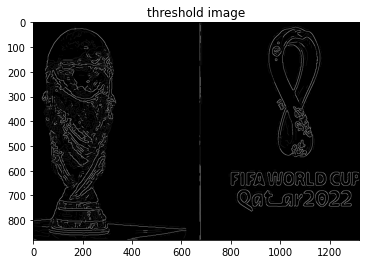

In [23]:
non_max_image = non_max_suppression(gradient_magnitude, gradient_direction)
threshold_image = threshold(non_max_image, 5, 20, 50)